## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 1: Basic Classifiers

In this task, you are going to implement two classifers and apply them to the  Fashion-MNIST dataset: 

(1) Logistic regression classifier

(2) Softmax classifier.

In [1]:
# Import modules, make sure you have installed all required packages before you start.
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Module auto reloading. (Ref: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html)
%load_ext autoreload
%autoreload 2

## Load Fashion-MNIST data

Fashion-MNIST is a widely used dataset mainly used for benchmarking the very basic machine learning models. Images are drawn from Zalando's clothing articles and the dataset consists of a training set with 60,000 examples and a test set with 10,000 examples. Each example is a 28x28 pixel grayscale image with an associated label from 10 classes. We will use this to create our training set, validation set, and test set.

See https://github.com/zalandoresearch/fashion-mnist for more details on Fashion-MNIST. 

### 10-class dataset Fashion-MNIST

First, we load the raw Fashion-MNIST data to create a 10-class dataset and manually define a label map.

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

# the integer labels in y_train and y_test correspond to the index of this label map
label_map = [
    't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

# Here we vectorize the data (rearranged the storage of images) for you. 
# That is, we flatten 1×28×28 images into 1×784 Numpy arrays.
# The reason we do this is because we can not put 2-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML models). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs in later assignments.

# Check the results
print('Raw training data shape: ', X_train_raw.shape)
print('Raw test data shape: ', X_test_raw.shape)

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

num_classes = max(y_train) + 1

print('Number of classes: ', num_classes)
print('Vectorized training data shape: ', X_train.shape)
print('Vectorized test data shape: ', X_test.shape)
print('Training labels shape: ', y_train.shape)
print('Test labels shape: ', y_test.shape)

Raw training data shape:  (60000, 28, 28)
Raw test data shape:  (10000, 28, 28)
Number of classes:  10
Vectorized training data shape:  (60000, 784)
Vectorized test data shape:  (10000, 784)
Training labels shape:  (60000,)
Test labels shape:  (10000,)


['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
(60000, 28, 28)


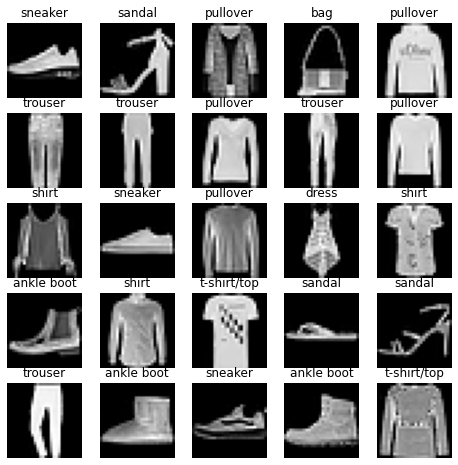

In [3]:
# We need to reshape vectorized data into the image format for visualization
X = X_train.reshape(X_train.shape[0], X_train_raw.shape[1], X_train_raw.shape[2])

print(label_map)
print(X.shape)

#Visualizing Fashion-MNIST data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5, 5, figsize=(8, 8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0], cmap='gray')
        axes1[j][k].set_title(label_map[y_train[i]])

In [4]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
#    Development data (binary) (only for gradient check in Part 1): 100 random samples from the subsampled binary train set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100
num_dev_binary = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (1000, 784)
Test labels shape:  (1000,)
Development data shape: (100, 784)
Development data shape (100,)


### 2-class dataset (Subsampled from Fashion-MNIST)

Next, in order to implement the experiment with the logistic regression classifier, we subsample the 10-class dataset to the 2-class dataset. 

In [5]:
# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
num_training_binary = X_train_binary.shape[0]
y_train_binary = y_train[y_train<2]
mask_binary = np.random.choice(num_training_binary, num_dev_binary, replace=False)

X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]

X_dev_binary = X_train_binary[mask_binary]
y_dev_binary = y_train_binary[mask_binary]

print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)
print('Development data (binary) shape:', X_dev_binary.shape)
print('Development labels (binary) shape', y_dev_binary.shape)

Train data (binary) shape:  (9775, 784)
Train labels (binary) shape:  (9775,)
Validation data (binary) shape:  (207, 784)
Validation labels (binary) shape:  (207,)
Development data (binary) shape: (100, 784)
Development labels (binary) shape (100,)


### Preprocessing

* Training data is 2D with shape (batch, dim)
* Subtract the mean value of all the dim, i.e. the mean should be computed along the batch (0-th) dimension

<font color="red"><strong>NOTE</strong></font>: We always use the statistics from the training set when normalizing validation & test sets

In [6]:
# For the 10-class dataset
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

# For the binary dataset
mean_image = np.mean(X_train_binary, axis=0)

X_train_binary = X_train_binary.astype(np.float32) - mean_image.astype(np.float32)
X_val_binary = X_val_binary.astype(np.float32) - mean_image
X_dev_binary = X_dev_binary.astype(np.float32) - mean_image

print('Train data mean: ', np.mean(X_train))
print('Validation data mean: ', np.mean(X_val))
print('Test data mean: ', np.mean(X_test))
print('Train data (binary) mean: ', np.mean(X_train_binary))
print('Validation data (binary) mean: ', np.mean(X_val_binary))
print('Development data (binary) mean: ', np.mean(X_dev_binary))

Train data mean:  2.8501714e-07
Validation data mean:  1.0094851884631397
Test data mean:  1.2234762598917117
Train data (binary) mean:  6.0910914e-08
Validation data (binary) mean:  -1.4547967447848702
Development data (binary) mean:  -3.357296929641421


## Part 0: Basics (5%)

In this part, you are going to get familiar with one of the very basic modeling methodologies of classification problems. 

<font color="red"><strong>NOTE</strong></font>: Without further specification, all vectors mentioned are considered column vectors. 

Let’s assume a training dataset $X$ of $N$ images that all have shape $(H, W, C)$, then $X \in R^{N \times D}$ where $D = H \times W \times C$. 

Consider a *flattened* image $x_i \in X$ with an associated label $y_i = \{1 \dots K\}$, where $i = 1 \dots N$ and $K$ represents the number of distinct classes. We have that $x_i \in R^D$, $y_i \in R$ and $y = (y_1, \dots, y_N)^T \in R^N$. 

For the Fashion-MNIST dataset we have training data `X_train` with shape $(49000, 784)$ and the corresponding labels `y_train` with shape $(49000,)$.

Here the number of input images $N = 49000$, and each image has a flattened dimension: $D = 28 \times 28 \times 1 = 784$. The total number of classes $K = 10$. 

For some $x_i \in R^D$, we will now define the score function $f(\cdot): R^D \to R^K$ that maps 
the $D$ pixels to $K$ different class scores:

$$f(x_i; W, b) = W^T x_i + b$$

where $W \in R^{D \times K}$ is a linear map and $b \in R^K$ represents the biases. 

Here we will use the **bias trick** to represent the two parameters ($W, b$) as one. Consider a concatenation on the data point $x_i$ and the weights $W$ given by

$$
\begin{aligned}
x_i &\gets[x_i; 1] \in R^{D + 1} \\ 
W &\gets [W; b] \in R^{(D + 1) \times K}
\end{aligned}
$$

which translates to:

- Extend the vector $x_i$ with one additional dimension that always holds the constant $1$
- Combine the original weights $W$ and biases $b$ to form a new weight matrix

The new score function will then simplify to a single matrix multiplication: 

$$f_i = f(x_i;W)=W^T x_i$$

Or equivalantly, 

$$f = \begin{bmatrix} f_1^T \\ \vdots \\ f_N^T \end{bmatrix} = X W$$

where $f \in R^{N \times K}$ are the class scores (logits) of all $K$ classes for each of the $N$ data points. Recall that $X = \begin{bmatrix} x_1^T \\ \vdots \\ x_N^T \end{bmatrix}$. 

For our data, $D + 1 = 784 + 1 = 785$ and the new weights $W \in R^{785 \times 10}$. 

<font color="red"><strong>TODO</strong></font>:  Implement the bias trick by extending the feature vectors. In our case this involves adding a bias dimension of ones to each of `X_train`, `X_val`, `X_test`, `X_dev`, `X_train_binary`, `X_val_binary`, and `X_dev_binary`.

<font color="red"><strong>HINT</strong></font>: Make your life easier with `np.hstack`. https://numpy.org/doc/stable/reference/generated/numpy.hstack.html

In [7]:
#############################################################
# TODO: Append the bias dimension of ones (i.e. bias trick) so that our models
# only have to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones([X_train.shape[0], 1])])
X_val = np.hstack([X_val, np.ones([X_val.shape[0], 1])])
X_test = np.hstack([X_test, np.ones([X_test.shape[0], 1])])
X_dev = np.hstack([X_dev, np.ones([X_dev.shape[0], 1])])
X_train_binary = np.hstack([X_train_binary, np.ones([X_train_binary.shape[0], 1])])
X_val_binary = np.hstack([X_val_binary, np.ones([X_val_binary.shape[0], 1])])
X_dev_binary = np.hstack([X_dev_binary, np.ones([X_dev_binary.shape[0], 1])])

# END of your code
#############################################################

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("X_dev shape: {}".format(X_dev.shape))
print("X_train_binary shape: {}".format(X_train_binary.shape))
print("X_val_binary shape: {}".format(X_val_binary.shape))
print("X_dev_binary shape: {}".format(X_dev_binary.shape))

X_train shape: (49000, 785)
X_val shape: (1000, 785)
X_test shape: (1000, 785)
X_dev shape: (100, 785)
X_train_binary shape: (9775, 785)
X_val_binary shape: (207, 785)
X_dev_binary shape: (100, 785)


## Part 1: Logistic Regression Classifier (5%)

In this part, you are going to implement a logistic regression classifier. 

Logistic regression classifier can solve a binary classification problem that has only two classes: $(0, 1)$. Therefore, it is reasonable for us to model only one of the two classes, and assign whatever else to the other class[3]. 

For some data $x_i \in X$ with corresponding label $y_i = \{0, 1\}$, we study the likelihood of this data point belonging to class "$1$", i.e. 

$$P(y_i = 1)$$ 

Here, we set $K = 1$ (because we're only modeling one class) so that we have a $1$-dimensional vector as the model weights (as opposed to a matrix descrbied in ***Part 0***): 

$$W \in R^{(D + 1) \times 1} \to w \in R^{D + 1}$$

Hence the logit for $x_i$ reads 

$$f_i = w^T x_i \in R$$

Now we define the likelihood of $x_i$ belonging to class $1$: 

$$P(y_i = 1 | x_i; w) = \frac{1}{1 + e^{-w^T x_i}} = \frac{1}{1 + e^{-f_i}} = \sigma (f_i)$$

where $\sigma (\cdot): R \to (0, 1)$ is the `sigmoid` function. 

Thus the likelihood for class $0$ follows 

$$P(y_i = 0 | x_i; w) = 1 - P(y_i = 1 | x_i; w) = 1 - \sigma (f_i)$$

so that the probabilities of class $1$ and class $0$ sum up to one. 

Hence, by setting a probability threshold $T = 0.5$, an example $x_i$ is classified as a positive example ($y_i = 1$) if 

$$\sigma_i = \sigma (f_i) > T$$

or equivalently if the score $f_i > 0$, and vice versa[3]. 

Consider the joint classification likelihood for class $1$ and class $0$ for some $x_i$:

$$
P(y_i | x_i; w) = \begin{cases} 
\sigma_i & \text{if } y_i = 1 \\ 
1 - \sigma_i & \text{else} 
\end{cases}
$$

which can then be written in a more compact form[3]: 

$$P_i = \sigma_i^{y_i} (1 - \sigma_i)^{1 - y_i}$$

The likelihood provides in general a probability of our model making a correct prediction. 

To measure the "goodness" of our predictions, we define the classification loss on $x_i$ using the ***negative*** of the log likelihood: 

$$L_i = -\log P_i = -y_i \log \sigma_i - (1 - y_i) \log (1 - \sigma_i)$$

Ultimately, we take the average over all samples for $i = 1 \dots N$ and add a regularization term:

$$L = \frac{1}{N} \sum_i L_i + \frac{\lambda}{2} \|w\|_2^2$$

where $\lambda$ is the regularization factor. 

This is an $L_2$ regularization, meaning that the regularization term is calculated by the $L_2$ norm of the coefficient $w$. Recall that

$$\|w\|_2 = \sqrt {w_1^2 + w_2^2 + \dots + w_K^2}$$

Therefore, the model can be learned by minimizing the loss function (i.e. maximizing the likelihood): 

$$w^* = \arg\min_w L$$

which can be achieved by gradient descent. The gradient of $L$ (and each $L_i$) w.r.t $w$ can be nicely formulated as 

$$\frac{\partial L_i}{\partial w} = -(y_i - \sigma_i) x_i$$

and therefore, 

$$\frac{\partial L}{\partial w} = -\frac{1}{N} \sum_i (y_i - \sigma_i) x_i + \lambda w$$

Or equivalently, 

$$\nabla_w L = -\frac{1}{N} X^T (y - \sigma) + \lambda w$$

where $\sigma = (\sigma_1, \dots, \sigma_N)^T \in R^N$. 

[1] http://cs231n.github.io/neural-networks-2/

[2] https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac

[3] Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction. 2nd ed. New York: Springer.

<font color="red"><strong>TODO</strong></font>: Based on the derivations given above, complete the code in **./utils/classifiers/logistic_regression.py**. You have to implement the classifier in two ways: 

* Naive method using for-loop
* Vectorized method

We provide the verification code for you to check if your implementation is correct. 

***Do not forget the $L_2$ regularization term in the loss.***

LR in Tensorflow is demonstrated in the verification code below. This step will familiarize you with TensorFlow functions.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below.

In [7]:
# Verification code for checking the correctness of the implementation of logistic_regression
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT

from utils.classifiers.logistic_regression import logistic_regression_loss_naive
from utils.classifiers.logistic_regression import logistic_regression_loss_vectorized

# generate initial weight vector
w = np.random.randn(X_train.shape[1]) * 0.0001
reg = 0.000005

## naive numpy implementation of Logistic Regression
loss_naive, grad_naive = logistic_regression_loss_naive(w, X_dev_binary, y_dev_binary, reg)

## vectorized numpy implementation of Logistic Regression
loss_vec, grad_vec = logistic_regression_loss_vectorized(w, X_dev_binary, y_dev_binary, reg)

## true value computed by tf
# here we specify float64 because this is the default float type in numpy, so
# an usual float32 may result in inconsistancy due to floating point error
w_tf = tf.Variable(w, dtype=tf.float64)
with tf.GradientTape() as tape:
     tape.watch(w_tf)
     loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          tf.Variable(y_dev_binary, dtype=tf.float64), 
          tf.linalg.matvec(tf.Variable(X_dev_binary, dtype=tf.float64), w_tf)
     )) + reg * tf.nn.l2_loss(w_tf)
     grad_true = tape.gradient(loss_true, w_tf)

## check the correctness
print('naive numpy loss: {}.'.format(loss_naive))
print('vectorized numpy loss: {}.'.format(loss_vec))
print('true loss: {}'.format(loss_true))
print('*'*100)
print('Relative naive gradient error is {}'.format(np.linalg.norm(grad_naive - grad_true)))
print('Relative vectorized gradient error is {}'.format(np.linalg.norm(grad_vec - grad_true)))
print('*'*100)
print('Is naive loss correct? {}'.format(np.allclose(loss_naive, loss_true)))
print('Is naive gradient correct? {}'.format(np.allclose(grad_naive, grad_true)))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_vec, loss_true)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_vec, grad_true)))

naive numpy loss: 0.7382685954958998.
vectorized numpy loss: 0.7382685954958998.
true loss: 0.7382685954958998
****************************************************************************************************
Relative naive gradient error is 1.6771353694282345e-13
Relative vectorized gradient error is 1.6366844550519394e-13
****************************************************************************************************
Is naive loss correct? True
Is naive gradient correct? True
Is vectorized loss correct? True
Is vectorized gradient correct? True


2022-10-14 13:39:28.830786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Part 2: Softmax Classifier (10%)

The softmax classifier generalizes the logistic regression classifier to multiple classes.

In the softmax classifier, the function mapping 

$$f(X; W) = X W: R^{N \times (D + 1)} \to R ^ {N \times K}$$

stays unchanged, but we now interpret the scores $f$ as the predicted probability distribution (unnormalized) over all classes for each data point. 

Again, to measure the goodness of our predictions, we replace the logistic regression loss (defined on $R$) with a cross-entropy loss (defined on $R^K$). For some (discrete) distributions $p, q \in R^K$, the similarity between them can be measured by the cross entropy: 

$$H(p, q) = -\sum_k p_k \log q_k: \Delta_K \times \Delta_K \setminus \{0, 1\} \to R_+$$

where $\Delta_K$ denotes the ***simplex*** in $R^K$: 

$$\Delta_K = \{x \in R^K: \sum_{i = 1}^K x_i = 1, x_i \ge 0 \text{ for } i = 1, \dots, K \}$$

and the symbol "$\setminus$" excludes the endpoints $\{0, 1\}$ from the domain of $q$. The definition of simplex corresponds to the notion of a probability distribution. 

Similarly, define the `softmax` function 

$$\sigma (s) = \frac{e^s}{\sum_k e^{s_k}}: R^K \to \Delta_K \setminus \{0, 1\}$$

which is just a `sigmoid` function generalized to $R^K$. 

For some $x_i \in X$ and corresponding label $y_i \in y$, the loss is defined by the cross entropy: 

$$L_i = H(p_i, \sigma_i) = -\sum_k p_{i, k} \log \sigma_{i, k} = -p_i^T \log \sigma_i$$

where $p_i=[0, \dots,1, \dots, 0] \in R^K$ is the ground truth distribution that contains a single $1$ at the $y_i$-th position (this is called a one-hot encoding), and 

$$\sigma_i = \sigma (W^T x_i) \in R^K$$

is the predicted (normalized) class distribution of $x_i$ w.r.t all $K$ classes. 

You can intuitively interprete the loss as a description of how far away your predicted distribution $\sigma$ is from the actual groud truth distribution $p$. 

Note that $W = (w_1, \dots, w_K) \in R^{(D + 1) \times K}$, $w_k \in R^{D + 1}$ is the mapping specifically on class $k$ and $\sigma_{i, k} = \sigma_i[k] = \sigma (w_k^T x_i)$ is the score of $x_i$ on class $k$. 

Thus the overall loss can be similarly given as: 

$$L = \frac{1}{N} \sum_i L_i + \frac{\lambda}{2} \|W\|_F^2$$

where $\|W\|_F = \sqrt{\sum_{i, j} W_{ij}^2}$ is the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm), and $\|W\|_F^2 = \sum_k \|w_k\|_2^2$ which corresponds to the $L_2$ norms with respect to the weights of each class. 

Similarly, the model learns by

$$W^* = \arg\min_W L$$

And the gradient w.r.t $w_k$ follows  

$$\frac{\partial L}{\partial w_k} = - \frac{1}{N} \sum_i (p_{i,k} - \sigma_{i, k}) x_i + \lambda w_k$$

Or equivalently, 

$$\frac{\partial L}{\partial W} = -\frac{1}{N} X^T (P - \sigma) + \lambda W$$

where $P = (p_1, \dots, p_N)^T \in R^{N \times K}$ and $\sigma = (\sigma_1, \dots, \sigma_N)^T \in R^{N \times K}$. 

<font color="red"><strong>NOTE</strong></font>: **Numerical Stability**. When you are writing code for computing the `softmax` function in practice, the intermediate terms $e^s$ and $\sum_k e^{s_k}$ may be very large due to the exponentials. Division with large numbers can be numerically unstable, so it is important to use the normalization trick. 

Notice that if we multiply both the top and the bottom of the fraction by constant $C$ and push $C$ inside the exponent, we get the following (mathematically equivalent) expression: 

$$
\sigma (s)
= \frac{e^s}{\sum_k e^{s_k}}
= \frac{C e^s}{C \sum_k e^{s_k}}
= \frac{e^{s + \log C}}{\sum_k e^{s_k + \log C}}
$$

A common choice for $C$ is to set $\log C= -\max_i s_i$.

<font color="red"><strong>TODO</strong></font>: Based on the derivations above, complete the code in **./utils/classifiers/softmax.py**. You have to implement the classifier in two ways: 

* Naive method using for-loop
* Vectorized method

We provide the verification code for you to check if your implementation is correct. 

***Do not forget the $L_2$ regularization term in the loss.***

Softmax in Tensorflow is demonstrated in the verification code below. This step will familiarize you with TensorFlow functions.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below.

In [8]:
# Verification code for checking the correctness of the implementation of softmax implementations
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.softmax import softmax_loss_naive
from utils.classifiers.softmax import softmax_loss_vectorized

## generate a random weight matrix of small numbers
#np.random.seed(3456)
W = np.random.randn(X_train.shape[1], num_classes) * 0.0001
reg = 0.000005

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc - tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc - tic))

# true value computed by tf
W_tf = tf.Variable(W, dtype = tf.float64)
tic = time.time()
with tf.GradientTape() as tape:
    tape.watch(W_tf)
    loss_true = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        tf.one_hot(tf.Variable(y_dev, dtype=tf.int32), num_classes), 
        tf.matmul(tf.Variable(X_dev, dtype=tf.float64), W_tf)
    )) + reg * tf.nn.l2_loss(W_tf)
    grad_true = tape.gradient(loss_true, W_tf)
toc = time.time()
print('true loss: {}, takes {} seconds'.format(loss_true, toc - tic))

## check the correctness
print('*'*100)
print('Relative loss error of naive softmax is {}'.format(np.linalg.norm(loss_true - loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(np.linalg.norm(loss_true - loss_vec)))
print('Gradient error of naive softmax is {}'.format(np.linalg.norm(grad_true - grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(np.linalg.norm(grad_true - grad_vec)))
print('*'*100)
print('Is naive softmax loss correct? {}'.format(np.allclose(loss_true, loss_naive)))
print('Is vectorized softmax loss correct? {}'.format(np.allclose(loss_true, loss_vec)))
print('Is naive softmax grad correct? {}'.format(np.allclose(grad_true, grad_naive,1e-02)))
print('Is vectorized softmax grad correct? {}'.format(np.allclose(grad_true, grad_vec,1e-02)))

naive numpy loss: 2.274372022967255, takes 0.49674105644226074 seconds.
vectorized numpy loss: 2.274372022967255, takes 0.0018620491027832031 seconds.
true loss: 2.2743720229672544, takes 0.010772943496704102 seconds
****************************************************************************************************
Relative loss error of naive softmax is 4.440892098500626e-16
Relative loss error of vectorized softmax is 4.440892098500626e-16
Gradient error of naive softmax is 1.7518080444747974e-13
Gradient error of vectorized softmax is 1.7386661955567984e-13
****************************************************************************************************
Is naive softmax loss correct? True
Is vectorized softmax loss correct? True
Is naive softmax grad correct? True
Is vectorized softmax grad correct? True


## Part 3: Train your classifiers (5%)

Now you can start to train your classifiers. Due to the fact that both the logistic regression and softmax classifer does not admit an analytical solution, we are going to use gradient descent algorithm for training. 

In the training section, you are asked to implement gradient descent optimization method, which can be interpreted as an attempt to minimize the loss function following iterative update of the model parameters using 

$$w \gets w - \alpha \nabla_w L$$

where $\alpha$ is the learning rate, and $\nabla_w L$ is the gradient of the loss $L$ w.r.t the coefficient $w$. 

<font color="red"><strong>TODO</strong></font>: The original code is given in **./utils/classifiers/basic_classifier.py**. You need to complete functions `train` and `predict`, in the class `BasicClassifier`. Later, you use its subclasses `LogisticRegression` and `Softmax` to train the model seperately and verify your result.

### Train Logistic Regression + Stochastic Gradient Descent (SGD)

<font color="red"><strong>TODO</strong></font>: Complete the code of subclasses `LogisticRegression` in **./utils/classifiers/basic_classifiers.py**. 

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below. The cell below will run correctly if your code is right.

In [9]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.basic_classifiers import LogisticRegression

## Logistic Regression + SGD
classifier = LogisticRegression()
reg = 1e-3 # regularization
lr = 1e-5 # learning rate
loss_hist_sgd = classifier.train(
    X_train_binary, y_train_binary, 
    learning_rate=lr, reg=reg, 
    num_iters=300, optim='SGD', 
    verbose=True
)

# Write the BasicClassifier.predict function and evaluate the performance 
# on both training set and validation set
y_train_pred = classifier.predict(X_train_binary)
print('training accuracy:', np.mean(y_train_binary == y_train_pred))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy:', np.mean(y_val_binary == y_val_pred))

iteration 0 / 300: loss 0.051413
iteration 100 / 300: loss 0.010421
iteration 200 / 300: loss 0.007177
training accuracy: 0.9969309462915601
validation accuracy: 0.9951690821256038


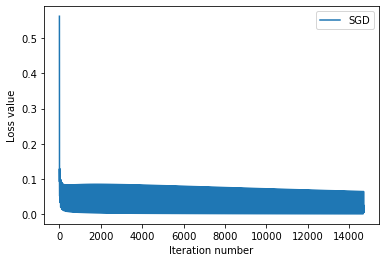

In [11]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

<font color="red"><strong>TODO</strong></font>: Complete the code of subclasses **Softmax** in **./utils/classifiers/basic_classifier.py**.

<font color="red"><strong>NOTE</strong></font>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [12]:
# THE FOLLOWING IS THE VERIFICATION CODE
# DO NOT CHANGE IT.

from utils.classifiers.basic_classifiers import Softmax

## Softmax + SGD
classifier = Softmax()
reg = 1e-3 # regularization
lr = 1e-5 # learning rate
loss_hist_sgd = classifier.train(
    X_train, y_train, 
    learning_rate=lr, reg=reg, 
    num_iters=300, optim='SGD', 
    verbose=True
)

# Write the BasicClassifier.predict function and evaluate the performance 
# on both the training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 300: loss 0.452576
iteration 100 / 300: loss 0.261787
iteration 200 / 300: loss 0.254880
training accuracy: 0.880224
validation accuracy: 0.858000


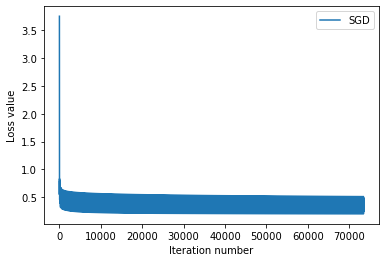

In [13]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()